# Spam SMS Detection

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Overview


The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. 
It contains one set of SMS messages in English of 5,577 messages, tagged acording being ham (legitimate) or spam

The files contain one message per line. Each line is composed by two columns: v1 contains the label (ham or spam) and v2 contains the raw text.

The dataset is taken from kaggle.

## Approach

- Loading Data

- Input and Output Data

- Applying Regular Expression

- Each word to lower case

- Splitting words to Tokenize

- Stemming with PorterStemmer handling Stop Words

- Preparing Messages with Remaining Tokens

- Preparing WordVector Corpus

- Applying Classification

## SMS Spam Classification Steps

- Data Preparation
- Exploratory Data Analysis(EDA)
- Text Pre-processing and TF-IDF
- Model Building with Classification Algorithm

In [5]:


# Importing libraries

from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

## 1. Data Preparation

In [6]:
df = pd.read_csv(r"/content/spam.csv",encoding='latin1')

In [7]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [8]:
df.tail()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
5571,ham,Rofl. Its true to its name,NaN,NaN,NaN
5572,ham,How are you doing? Hope you've settled in for ...,NaN,NaN,NaN
5573,spam,Give me your account number,NaN,NaN,NaN
5574,spam,REMINDER FROM O2: To get 2.50 pounds free call...,NaN,NaN,NaN
5575,ham,Hahaha....you are so funny,NaN,NaN,NaN


In [9]:
#Dropping unnecessary columns
df = df[df.columns.drop(list(df.filter(regex='Unnamed')))]
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
import numpy as np
df['Count']=0
for i in np.arange(1,len(df.v2)):
    df.loc[i,'Count'] = len(df.loc[i,'v2'])

In [11]:
df.head()

,v1,v2,Count
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [12]:
df.tail()


,v1,v2,Count
5571,ham,Rofl. Its true to its name,26
5572,ham,How are you doing? Hope you've settled in for ...,92
5573,spam,Give me your account number,27
5574,spam,REMINDER FROM O2: To get 2.50 pounds free call...,147
5575,ham,Hahaha....you are so funny,26


In [13]:
#Total ham(0) and spam(1) messages
df['Count'].value_counts()

22     123
24     101
32      96
23      94
26      88
      ... 
226      1
230      1
234      1
242      1
0        1
Name: Count, Length: 274, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5576 entries, 0 to 5575
Data columns (total 3 columns):
v1       5576 non-null object
v2       5576 non-null object
Count    5576 non-null int64
dtypes: int64(1), object(2)
memory usage: 130.8+ KB


In [14]:
corpus = []
ps = PorterStemmer()

In [15]:
# Original Messages

print (df['v1'][1])
print (df['v2'][3])

ham
U dun say so early hor... U c already then say...


## 2. Exploratory Data Analysis

In [16]:
df.groupby('v1').describe()

Count                                                         
       count        mean        std   min    25%    50%    75%    max
v1                                                                   
ham   4827.0   70.962710  57.996194   0.0   33.0   52.0   92.0  910.0
spam   749.0  138.285714  29.302152  13.0  132.0  149.0  157.0  223.0

In [17]:
#Replacing column names
df.rename(columns={'v1':'label','v2':'sms'},inplace=True)

In [18]:
df.label.value_counts()

ham     4827
spam     749
Name: label, dtype: int64

In [19]:
df.sms.value_counts()

Sorry, I'll call later                                                                                                                                 30
I cant pick the phone right now. Pls send a message                                                                                                    12
Ok...                                                                                                                                                  10
Okie                                                                                                                                                    4
Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am-11pm as you have WON a guaranteed ?1000 cash or ?5000 prize!     4
                                                                                                                                                       ..
How about getting in touch with folks waiting for company? Just txt back you

In [20]:
df.groupby('sms').describe()

Count         ...              
                                                   count   mean  ...    75%    max
sms                                                              ...              
 &lt;#&gt;  in mca. But not conform.                 1.0   36.0  ...   36.0   36.0
 &lt;#&gt;  mins but i had to stop somewhere fi...   1.0   51.0  ...   51.0   51.0
 &lt;DECIMAL&gt; m but its not a common car her...   1.0  132.0  ...  132.0  132.0
 and  picking them up from various points            1.0   41.0  ...   41.0   41.0
 came to look at the flat, seems ok, in his 50s...   1.0  103.0  ...  103.0  103.0
...                                                  ...    ...  ...    ...    ...
yay! finally lol. i missed our cinema trip last...   1.0   56.0  ...   56.0   56.0
yeah sure thing mate haunt got all my stuff sor...   1.0  142.0  ...  142.0  142.0
yeah, that's what I was thinking                     1.0   32.0  ...   32.0   32.0
yes baby! I need to stretch open your pussy!         1.0   44.0  ...   44.0   44.0
you are sweet as well, princess. Please tell me...   1.0   81.0  ...   81.0   81.0

[5171 rows x 8 columns]

In [21]:
df.groupby('label').describe()

Count                                                         
        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4827.0   70.962710  57.996194   0.0   33.0   52.0   92.0  910.0
spam    749.0  138.285714  29.302152  13.0  132.0  149.0  157.0  223.0

### Inference
We can see the top msgs in ham and spam. Please call our customer service rep seems to be the most common spam message.

In [27]:
df.groupby('label').describe()

Count                                                         
        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4827.0   70.962710  57.996194   0.0   33.0   52.0   92.0  910.0
spam    749.0  138.285714  29.302152  13.0  132.0  149.0  157.0  223.0

In [ ]:
#Replacing column names
df.rename(columns={'v1':'label','v2':'sms'},inplace=True)

In [ ]:
df.label.value_counts()
df.head()

,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [22]:

df['sms length'] = df['sms'].apply(len)
df.head()

,label,sms,Count,sms length
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,29,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,155
3,ham,U dun say so early hor... U c already then say...,49,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,61


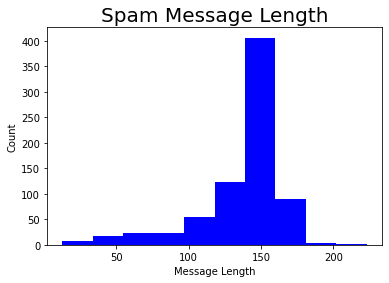

In [23]:

# Plotting length of sms text for spam sms
plt.hist(df[df['label']=='spam']['sms length'],color='blue',bins=10)
plt.title('Spam Message Length',fontsize=20)
plt.xlabel('Message Length')
plt.ylabel('Count')
plt.show()

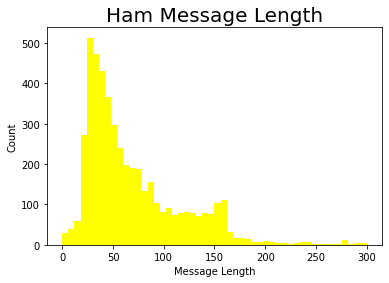

In [24]:
# Plotting length of sms text for spam sms
plt.hist(df[df['label']=='ham']['sms length'],color='yellow',bins=50,range=(0,300))
plt.title('Ham Message Length',fontsize=20)
plt.xlabel('Message Length')
plt.ylabel('Count')
plt.show()

### Inference
We can see that sms with longer text tend to be spam.

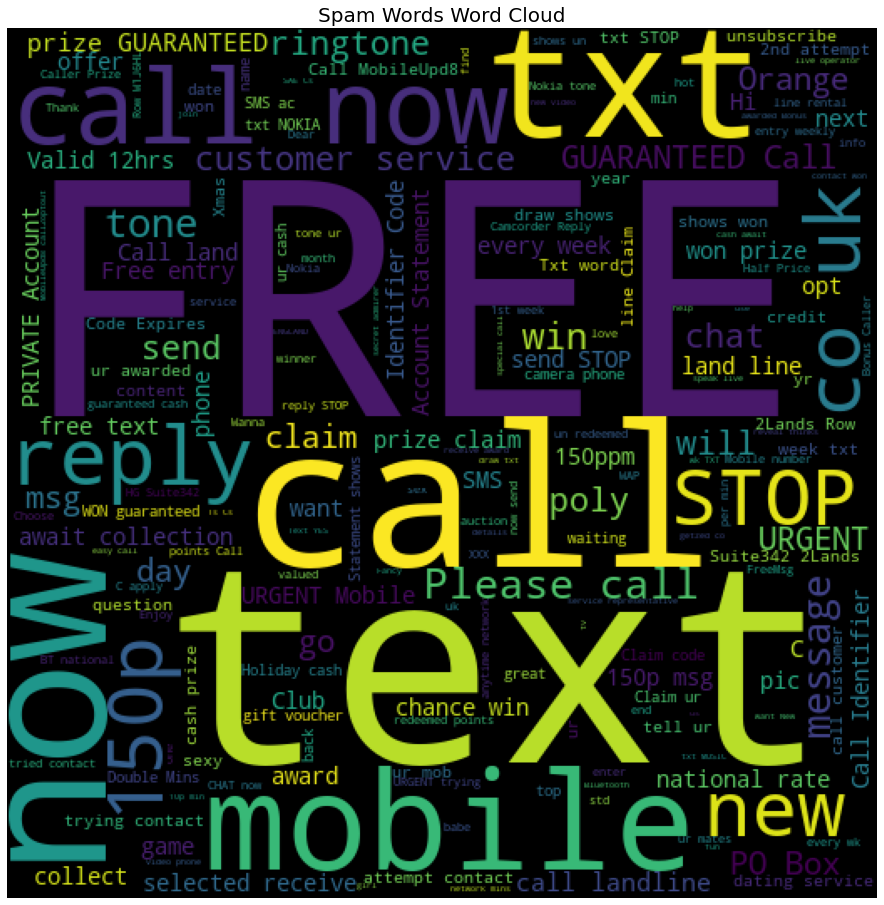

In [25]:
spam_words = ' '.join(list(df[df['label'] == 'spam']['sms']))
spam_wc = WordCloud(width=520,height=520).generate(spam_words)
plt.figure(figsize=(16,16))
plt.imshow(spam_wc)
plt.axis("off")
plt.title("Spam Words Word Cloud",fontsize=20)
plt.show()

### Inference
We can see that sms containing words FREE,Please Call, Now , Win,Text,Call tend to be very common spam words

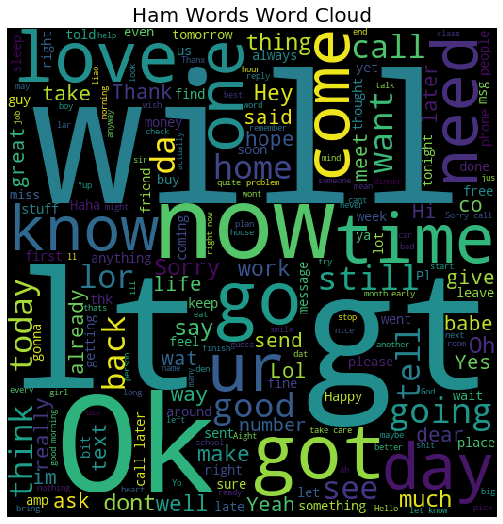

In [ ]:
ham_words = ' '.join(list(df[df['label'] == 'ham']['sms']))
ham_wc = WordCloud(width=520,height=520).generate(ham_words)
plt.figure(figsize=(16,9))
plt.imshow(ham_wc)
plt.axis("off")
plt.title("Ham Words Word Cloud",fontsize=20)
plt.show()

### Inference
We can see the most common ham sms contain words will, know, gt (got), OK, know, Love,now.

# 3.Text Preprocessing

In [26]:
#Processing Text - removing stopwords, punctuation and apply stemming
import string
ps = PorterStemmer()

def process_sms(sms):
    ''' This function removes punctuations and returns the sms as a list of words'''
    sms = sms.translate(str.maketrans('','',string.punctuation)) #remove punctuations
    sms = sms.split()
    sms = [ps.stem(word) for word in sms if len(word) > 2]
    sms = ' '.join(sms)
    return sms

In [27]:
df['sms'] = df.sms.apply(process_sms) #took about 2 mins to execute
df.head()

,label,sms,Count,sms length
0,ham,until jurong point crazi avail onli bugi great...,0,111
1,ham,lar joke wif oni,29,29
2,spam,free entri wkli comp win cup final tkt 21st ma...,155,155
3,ham,dun say earli hor alreadi then say,49,49
4,ham,nah dont think goe usf live around here though,61,61


In [28]:
# convert label to a numerical variable
df['label']=df.label.map({'ham':0,'spam':1})
df.head()

,label,sms,Count,sms length
0,0,until jurong point crazi avail onli bugi great...,0,111
1,0,lar joke wif oni,29,29
2,1,free entri wkli comp win cup final tkt 21st ma...,155,155
3,0,dun say earli hor alreadi then say,49,49
4,0,nah dont think goe usf live around here though,61,61


In [29]:
#Dropping unnecessary columns
df = df[df.columns.drop(list(df.filter(regex='Unnamed')))]
df.head()

,label,sms,Count,sms length
0,0,until jurong point crazi avail onli bugi great...,0,111
1,0,lar joke wif oni,29,29
2,1,free entri wkli comp win cup final tkt 21st ma...,155,155
3,0,dun say earli hor alreadi then say,49,49
4,0,nah dont think goe usf live around here though,61,61


## Using TF-IDF


Tf-idf stands for term frequency-inverse document frequency, and the tf-idf weight is a weight often used in information retrieval and text mining.TF means Term Frequency. It measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length as a way of normalization.

TF = (Number of times term w appears in a document) / (Total number of terms in the document)

Second part idf stands for Inverse Document Frequency. It measures how important a term is. While computing TF, all terms are equally important. 

IDF = log_e(Total number of documents / Number of documents with term w in it)


In [47]:
#stop words refer to useless words
#removing the useless words 
tfidf = TfidfVectorizer(encoding='latin-1',stop_words='english',analyzer='word',lowercase=True,smooth_idf=True)


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='latin-1',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)


In [64]:
#Splitting into train test set
#By specifying the train_size as 0.75, we aim to put 75% of the data into our training set, and the rest of the data into the test set
#If you don't specify the random_state in the code, then every time you run(execute) your code a new random value is generated and the train and test datasets would have different values each time.However, if a fixed value is assigned like random_state = 0 or 1 or 42 or any other integer then no matter how many times you execute your code the result would be the same .i.e, same values in train and test datasets.

X_train,X_test,y_train,y_test = train_test_split(df['sms'],df['label'],test_size = 0.3, random_state =7)

In [71]:
#fit() : used for generating learning model parameters from training data
#transform() : parameters generated from fit() method,applied upon model to generate transformed data set.
#fit_transform() : combination of fit() and transform() 
#Matrices that contain mostly zero values are called sparse, distinct from matrices where most of the values are non-zero, called dense.
#A feature is a measurable property of the object you’re trying to analyze. In datasets, features appear as columns:

features_train = tfidf.fit_transform(X_train)
features_test = tfidf.transform(X_test)
print(features_train)
print(pd.DataFrame(features_train.todense(),columns=tfidf.get_feature_names()))

  (0, 2133)	0.6455190571005058
  (0, 4886)	0.41861277529657853
  (0, 4451)	0.638802388284961
  (1, 4857)	0.3274451475128587
  (1, 2611)	0.40105400173561573
  (1, 5542)	0.19383417932279176
  (1, 5748)	0.345164492538777
  (1, 2028)	0.3338125500090695
  (1, 2432)	0.21467827626218178
  (1, 1687)	0.4363163560004069
  (1, 5878)	0.30583013972381173
  (1, 5669)	0.3657916474708246
  (2, 1178)	0.38988457197736764
  (2, 6077)	0.3381008414431073
  (2, 1837)	0.26153657400329783
  (2, 4697)	0.41998292438806495
  (2, 2731)	0.6120282887628782
  (2, 3584)	0.3381008414431073
  (3, 43)	0.313265513233639
  (3, 1404)	0.22916229290308604
  (3, 1619)	0.24489688209025554
  (3, 3337)	0.21820080325483923
  (3, 5804)	0.5019972536691677
  (3, 2163)	0.2797974770059525
  (3, 3769)	0.21957929003882232
  :	:
  (3900, 1357)	0.4684937661551958
  (3900, 2291)	0.4000621064252349
  (3900, 4423)	0.3863341595798679
  (3900, 2343)	0.4000621064252349
  (3900, 1994)	0.33052688215230475
  (3900, 3625)	0.3283844668954942
  (3900

# 4. Model Building

## Naive Bayes

Generally, Naive Bayes works well on text data.

Multinomial Naive Bayes calculates likelihood to be count of an word/token (random variable) unlike Gaussian Naive Bayes and hence I would use Multinomial Naive Bayes model.

In [72]:
model = MultinomialNB()
print(model.fit(features_train,y_train))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


In [74]:
#accuracy is closeness of the measurements to a specific value,
#precision is the closeness of the measurements to each other.
#In statistical analysis of binary classification, the F1 score (also F-score or F-measure) is a measure of a test's accuracy.
#recall is the number of correct results divided by the number of results that should have been returned.
#In binary classification, recall is called sensitivity. 
#It can be viewed as the probability that a relevant document is retrieved by the query.
prediction = model.predict(features_test)
print(prediction)
print(accuracy_score(y_test,prediction))
print(classification_report(y_test,prediction))

[0 0 0 ... 0 0 0]
0.9509862522414824
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1450
           1       0.99      0.64      0.78       223

    accuracy                           0.95      1673
   macro avg       0.97      0.82      0.87      1673
weighted avg       0.95      0.95      0.95      1673



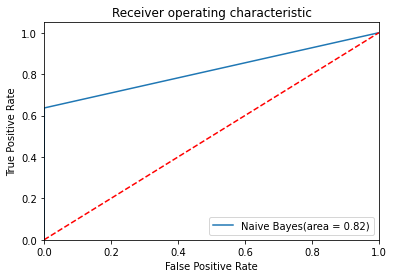

In [38]:
from sklearn import metrics 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

nb_roc_auc = roc_auc_score(y_test,prediction)
fpr, tpr, thresholds = roc_curve(y_test,prediction)
plt.figure()
plt.plot(fpr, tpr, label='Naive Bayes(area = %0.2f)' % nb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [39]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(features_train,y_train)
prediction_knn = model.predict(features_test)
print(accuracy_score(y_test,prediction_knn))
print(classification_report(y_test,prediction_knn))

0.9043634190077705
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1450
           1       1.00      0.28      0.44       223

    accuracy                           0.90      1673
   macro avg       0.95      0.64      0.69      1673
weighted avg       0.91      0.90      0.88      1673



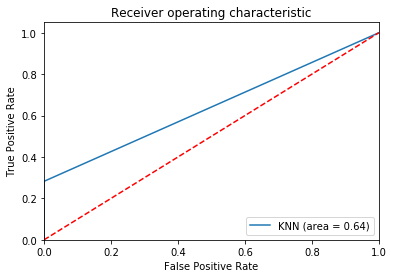

In [ ]:
knn_roc_auc = roc_auc_score(y_test,prediction_knn)
fpr, tpr, thresholds = roc_curve(y_test,prediction_knn)
plt.figure()
plt.plot(fpr, tpr, label='KNN (area = %0.2f)' % knn_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Decision Tree

In [40]:
model = DecisionTreeClassifier(random_state=50)
model.fit(features_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=50, splitter='best')

In [42]:
# Predicting
y_pred_dt = model.predict(features_test)

In [43]:
# Evaluating
cm = confusion_matrix(y_test, y_pred_dt)

print(cm)

[[1436   14]
 [  63  160]]


In [45]:
print ("Accuracy : %0.5f \n\n" % accuracy_score(y_test, model.predict(features_test)))
print (classification_report(y_test, model.predict(features_test)))

Accuracy : 0.95397 


              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1450
           1       0.92      0.72      0.81       223

    accuracy                           0.95      1673
   macro avg       0.94      0.85      0.89      1673
weighted avg       0.95      0.95      0.95      1673



## Final Result based on Accuracy

* Decision Tree : 95.39%
* KNN classifier : 90.43%
* Multinomial Naive Bayes:95.09%    